<center>
    <b><h1> Couserwork Assignment: Text Classification</h1></b>
</center>

<center>
    <h3>University of London</h3>
</center>

<center>
    <h3>BSc in Computer Science</h3>
</center>

<center>
    <h3>Natural Language Processing</h3>
</center>

<div style="page-break-after: always;"></div>

<h1> Table of Content</h1>

<style>
ul {
    font-size: 20px;
}

ul ul {
    font-size: 15px;
}
</style>

<ul>
    <li>
        <a href="#intro">1. Introduction</a>
        <ul>
            <li><a href="#1.1">1.1 Problem Area</a></li>
            <li><a href="#1.2">1.2 Objectives</a></li>
            <li><a href="#1.3">1.3 Choice of Dataset</a></li>
        </ul>
    </li>
    <li>
        <a href="#implementation">2. Implementation</a>
        <ul>
            <li><a href="#2.1">2.1 Processing</a></li>
            <ul>
                <li><a href="#2.1.1">2.1.1 Data Extraction and Cleaning</a></li>
                <li><a href="#2.1.2">2.2.2 Prelimary Data Exploration and Data Cleaning</a></li>
                <li><a href="#2.1.3">2.3.3 Vocabulary statistic</a></li>
            </ul>
            <li><a href="#2.2">2.2 Baseline performance</a></li>
        </ul>
    </li>
    <li>
        <a href="#Conc">3. Conclusion</a>
        <ul>
            <li><a href="#3.1">3.1 Evaluation</a></li>
            <li><a href="#3.2">3.2 Project Evaluation and Summary</a></li>
        </ul>
    </li>
</ul>


<div style="page-break-after: always;"></div>

<h2 id="intro">1. Introduction</h2>
<h3 id="1.1">1.1 Problem area</h3>

Our current generation has witnessed unprecedented global growth, be it in the economy or technology sectors. However, since the late 2010s, the landscape has undergone significant transformations. The conflicts around the world, deceleration in multiple sectors, and rise of protectionism have posed challenges to the old strategy of relying solely on continuous economic expansion. This challenge is fuelled by the unfavorable economic outlook observed since the 2020s. As a result, individuals have become more conservative and cautious in their spending habits. Consequently, businesses across sectors must vigilantly monitor shifts in consumer sentiment. By extracting insights from sentiment analysis, companies can understand consumer attitudes toward their products and services, as well as their overall brand image. This knowledge enables companies to promptly adapt and implement new strategies, ensuring their relevance in this volatile economic environment.

The film industry has been severely impacted by declining attendance, attributed to both slowing economic growth and a lack of compelling content. (sg) The coronavirus pandemic has further exacerbated the situation with lockdowns and admission restrictions. (us) Movie theaters now face fierce competition from alternative entertainment sources, especially video games, which experienced an impressive 20% growth in 2020. (us) To ensure continued prosperity, industry decision-makers must promptly reassess their strategies, giving paramount importance to audience opinions and feedback. Sentiment analysis becomes a critical tool for understanding audience preferences and sentiments, enabling the film industry to adapt and thrive in an ever-evolving entertainment landscape.

Despite the prevailing economic challenges, the film industry achieved a remarkable milestone in 2019, surpassing the $101 billion USD mark. This multi-billion-dollar industry still holds significant potential for prosperity. While attracting new consumers to choose movies as their primary source of entertainment may present difficulties, companies can focus on retaining their existing viewer base. Leveraging sentiment analysis, specifically tailored to movie reviews, becomes essential as it provides valuable insights into viewers' preferences and dislikes. By incorporating these insights, future movie productions can effectively cater to the preferences of the target audience, fostering continued success in the industry.

Factually speaking, the internet has become a vast database of opinions created by consumers. They express their thoughts through various channels such as Twitter, Facebook, IMDB, and Rotten Tomatoes. The model developed for sentimental analysis for the film industry can be transferred to and utilized in other sectors of the economy.  With appropriate refinement, this model has the potential to provide valuable insights into user sentiments in domains that may not have direct connections to the film industry. This demonstrates the versatility and applicability of sentiment analysis beyond its initial scope, offering a valuable tool for understanding consumer sentiment in diverse fields.

Word Count:436

<h3 id="1.2">1.2 Objective</h3>

The <b>objective</b> of this research is to conduct sentiment analysis on movie reviews utilizing text classification models. The project's focus will be on implementing and comparing the effectiveness of different classification algorithms. 

The <b>aim</b> of this project will be categorizing users' movie reviews into binary classes of positive or negative sentiments. 

This research aims to contribute to the field of sentiment analysis by adding to the knowledge of users' sentiment towards movies and using this knowledge to provide valuable insights for the film industry.

While it is true that there have been many researches conducted on sentiment analysis and its application in the film industry, this particular research still holds its value and relevance. Granted that this is not groundbreaking research in this sector, it still <b>contributes to the existing body of knowledge</b> and <b>provides more insights</b>, and has the potential to be applied elsewhere. 

The insights are essential to <b>filmmakers, production companies</b>, and other stakeholders such as <b>investors and actors/actresses</b> to make informed decisions with regard to content creation, marketing, investments, and engagement with the audience.

The result of this research can be implemented further in other sectors as a form of <b>Transfer Learning</b>. For instance, it can be used to examine the positive and negative sentiment in other reviews such as music reviews and Application stores reviews. 

The implementation of this research will consist of the following parts:

<b>Data Cleaning and Processing</b>: 
This section aims to obtain the data and prepare it for further analysis. The data will need to be cleaned, consistent, and balanced at the end. It will identify and remove irrelevant features while focusing on important ones. 

<b>Simple Textual Analysis</b>: Simple analysis without the use of machine learning and neural networks will be conducted. It would include analysis such as Lexical analysis and word frequency distribution.

<b>Building Classfication Models</b>:  
Multiple Machine Learning Classification models will be constructed and trained on the processed data. These models aim to categorize the comments on the movies into positive and negative sentiments, enabling the analysis of user opinions. 

<b>Performance Evaluation</b>: The models constructed will undergo evaluations and comparisons using metrics such as accuracy, recall, and F1-score, together with the baseline model. The best-performing model will be identified by its ability to accurately classify the comments into positive and negative sentiments.

<b>Conclusion</b>: Final findings will be concluded from two perspectives, building the model for future use (Performance Evaluation) and analysis of current data (Simple Textual Analysis). It allows more informed conclusions regarding sentiment analysis and its applicability to movie comments.


Word Count: 420

<h3 id="1.3">1.3 Choice of Dataset</h3>

It is essential to choose a good choice of data. A range of data from many websites was considered, including the Rotten Tomatoes movies and critic reviews dataset and Top Popular Movie Review Data Set from Kaggle. Ultimately, the Large Movie Review Dataset was chosen due to its large size. 

The dataset is available to download from [here](https://ai.stanford.edu/~amaas/data/sentiment/). It is in the compressed tar format. It contains movie reviews with their associated binary sentiment labels. The dataset contains 50,000 reviews split into 25k for training and 25k for testing. This data set is a balanced dataset with an equal number of contains labeled as positive and negative.

The data is stored in a text document in two folders, one for 'pos', and another for 'neg'. Each document's name will contain its unique ID and the corresponding rating. As the data is not stored in the traditional CSV format, an algorithm will be needed to extract the information for the folder.

The data is obtained from the Stanford Artificial Intelligence Laboratory, a laboratory at Stanford University. This a credible data that has also been widely used in research for many years. Although Dr. Andrew Maas, the first author of this dataset, did not explicitly specify the term of usage, the dataset is publicly available from the school's website.

From an ethical point of view, the data did not include personal information about the creator of the review, making this have a high level of anonymity. Yet, a link is provided for every unique ID in the data, linking to the user comment page of the movie. This practice ensures the user remains largely anonymous while providing clues for data analysts to trace back to the movies if required.

In summary, thorough research is conducted to find the Large Movie Review Dataset due to its large size and availability. This makes it an ideal source for sentimental analysis as it offers a substantial amount of diverse data with labels. 

Word Count 327

<h3 id="1.4">1.4 Evaluation Methodology</h3>

To effectively assess the performance of the models in this project Evaluation metrics such as accuracy, presision, recall and F1 score will be used. The confusion matrix will also be analysed. However, the main focus will be on comparing the accuracy across the models and the baseline. 

With reference to the formula below, accuracy measures the overall correctness of the classification model by calculating the correctly classfied samples over all of the samples

$$
 \text{Accuracy} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Samples}}
 $$

Precision, on the other hand, only considers those which are correctly classified as positive.

$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

Recall finds those which are correctly labbeled as positive among those which are actually positive.

$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

F1 score provides a balanced measure of the model's performance by combining both precision and recall. It considers the model's ability to correctly identify positive instances.

$$
\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} 
$$

Confusion matrix provides the summary of the overall performance of the model by displaying the number for true positives, true negatives, false positives, and false negatives. It is a detailed breakdown of the models prediction against the actual sentiment.

In this study, accuracy will be the primary evaluation metric as it provides a balanced consideration of both positive and negative sentiments. However, during the optimization of the models, other metrics such as precision, recall, and F1-score may also be considered. Nevertheless, for the purpose of evaluation across all models, accuracy will be the sole metric utilized.

Word Count: 246

<h2 id="implementation">2. Implementation</h2>
<h3 id="2.1">2.1 Processing</h3>
<h3 id="2.1.1">2.1.1 Data extraction</h3>

In [92]:
# Import library needed for data analysis

# os is used for handling the system
import os

# random for randomly selecting the data
import random

# pandas for storing and handling the data in data frame
import pandas as pd

# matplotlib for visualising the data
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Regular expression handling
import re

# Numpy for calculation
import numpy as np

# NLTK for natural language processing
import nltk
from nltk.corpus import stopwords #stop words removal
from nltk.stem import WordNetLemmatizer #replace words with similar meaning
from nltk.tokenize import word_tokenize #tokenizing the string
from nltk import ne_chunk
from nltk.tree import Tree
from nltk.collocations import BigramCollocationFinder #collation calculation
from nltk.metrics import BigramAssocMeasures #collation calculation
from nltk.probability import FreqDist #distribution calculation

# spliting of data into test and train dataset
from sklearn.model_selection import train_test_split

# RNN
from tensorflow.keras.preprocessing.text import Tokenizer #tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences #padding
from tensorflow.keras.models import Sequential #deeplearning model
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense #deeplearning layers
from tensorflow.keras import regularizers # regularisation

# Navie Bayes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# SVM
from sklearn.svm import SVC

# BoW
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# Logistic regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

# comparison
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Bert
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error

# wordcould display
from wordcloud import WordCloud

Data will be extracted and stored locally. To extract the data required for the Natural Language Processing, some libraries such as pandas, numpy and os were imported.

The location of the data file is specified to extract the data

In [2]:
# Path to the folders
pos_folder = r'C:\Users\xjie\Documents\SIM\Y3S2\nlp\aclImdb\train\pos'
neg_folder = r'C:\Users\xjie\Documents\SIM\Y3S2\nlp\aclImdb\train\neg'

<b>Format of data:</b> As the data obtained is in the form of text document stored in positive and negative sentiment folder with each individual file name as the rating and the ID, a file counter is needed to check for the length of the data

In [3]:
# Helper functions;

# Count the number of files in the data folder
def count_files(folder_path):
    if not os.path.isdir(folder_path):
        print(f"Error: {folder_path} is not a valid directory.")
        return

    file_count = 0

    for _, _, files in os.walk(folder_path):
        file_count += len(files)

    return file_count

Using the function as define above, the number of the files in both positive and negative folder are obtained: 

In [4]:
# Positive data file avaliable
file_count = count_files(pos_folder)
print(f"The number of files in positive data folder is: {file_count}")

The number of files in positive data folder is: 12500


In [5]:
# Negative data file avaliable 
file_count = count_files(neg_folder)
print(f"The number of files in nagtive data folder is: {file_count}")

The number of files in nagtive data folder is: 12500


As this training data set is <b>too big</b> for the computer, only <b>5000 data</b> from positive and negative folder respectively will be selected to make the program runs faster. Then these data will be further seperated into test and training sets. These data will be selected using the random library.

Some helper functions are defined to extract the information and data from the data folder:

In [6]:
# Helper functions

# Function to extract unique ID and rating from file name
def extract_info(file_name):
    id_rating = file_name.split('.')[0]
    unique_id, rating = id_rating.split('_')
    return int(unique_id), int(rating)

# Function to extract the data from the file based on the aclImdb data structure
def extract_files(folder, num_files, sentiment):
    files = random.sample(os.listdir(folder), num_files)
    data = pd.DataFrame(columns=['Sentiment', 'Unique ID', 'Rating', 'Content'])
    
    for file_name in files:
        file_path = os.path.join(folder, file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read() # read content for the review
        unique_id, rating = extract_info(file_name)  # get ID and rating from file name
        file_data = pd.DataFrame({'Sentiment': [sentiment], 'Unique ID': [unique_id], 'Rating': [rating], 'Content': [content]})
        data = pd.concat([data, file_data], ignore_index=True)
    
    return data

Randomly extract 5000 data from the folder

In [7]:
# Helper functions
# Extracting data
pos_data = extract_files(pos_folder, 5000, 'pos')
neg_data = extract_files(neg_folder, 5000, 'neg')

# Print the resulting DataFrame
raw_data = pd.concat([pos_data, neg_data], ignore_index=True)

# Display the start of the data
raw_data.head()

,Sentiment,Unique ID,Rating,Content
0,pos,1733,7,Much underrated camp movie on the level of Cob...
1,pos,9634,8,This is an unusual Laurel & Hardy comedy with ...
2,pos,1135,9,I first saw this in the movie theater when it ...
3,pos,2391,10,My husband and I enjoy The DoodleBops as much ...
4,pos,11922,10,One of Disney's best films that I can enjoy wa...


<br>

<h3 id="2.1.2">2.1.2 Prelimary Data Exploration and Data Cleaning</h3>

In [8]:
# Examining the data
raw_data.describe()

,Sentiment,Unique ID,Rating,Content
count,10000,10000,10000,10000
unique,2,8015,8,9987
top,pos,11168,1,"God, I was bored out of my head as I watched t..."
freq,5000,2,2009,2


It was noted that both Unique ID and Content has duplicated values after the extraction as the frequency of the data is not 1. 

However, it is <b>not ideal</b> for the model to take in repeated reading in the content field as it does not add any more knowlegde to the model. Moreover, the original unique ID also do not provide much information after combining the data from both positive sentiment and negative sentiment.

Thus, an algorithm will be implemented to check for these values and handle them.

<b>For duplicates in Unique ID</b>, as a <b>new ID will be assigned</b> as the index for the data frame, there is <b>no need</b> for the Unique ID from positive sentiment and negative sentiment folder. Thus, the <b>unique ID column will be dropped</b>. 

<b>For duplicates in content</b>, it will first find the duplicates, then remove the <b>first instance</b> of the duplicates. To ensure the overall dataset remain balanced, it will perform the random selection of data from the original data file again. These two functions will be <b>called recursively</b> until there is <b>no repetition</b> in the dataframe. The cleaned data will be saved in a new data frame.

<h4>Removing duplicates and old Unique ID</h4>

In [9]:
# Remove unique ID column from the data
org_ID_removed_data = raw_data.drop("Unique ID", axis=1)

finding the dupicates

In [10]:
# Helper function
# Check for repetetion of data
def find_duplicates(dataframe, column):
    duplicates = dataframe[dataframe[column].duplicated(keep=False)]
    duplicates_sorted = duplicates.sort_values(by=column)

    if duplicates_sorted.empty:
        print("No repeated data entry found.")
    else:
        print("Repeated data entry/entries found in "+str(column))
        duplicates_pairs = duplicates_sorted.groupby(column).apply(lambda x: x.reset_index(drop=True))
        duplicates_pairs.reset_index(drop=True, inplace=True)
        return duplicates_pairs

As there could still be duplicates present in the new files that are added, a recursive algorithm is used to check and replace the replicate until there is no more repeated entries

In [11]:
# Helper function
# replace duplicates with other values
def get_balance_data_with_duplicates(duplicate_content, original_data, pos_folder, neg_folder):
    # Remove the first occurrence of unique items in the duplicated content
    data_to_remove = duplicate_content.drop_duplicates(subset='Content', keep='first')
    org_ID_removed_data = original_data.drop_duplicates(subset='Content', keep='first')

    # Count the number of pos and neg entries in 'data_to_remove'
    pos_count = data_to_remove[data_to_remove['Sentiment'] == 'pos'].shape[0]
    neg_count = data_to_remove[data_to_remove['Sentiment'] == 'neg'].shape[0]

    # Add the removed duplicates such that the data is balanced
    added_pos_data = extract_files(pos_folder, pos_count, 'pos')
    added_neg_data = extract_files(neg_folder, neg_count, 'neg')

    # Remove the 'Unique ID' column from added data
    added_pos_data.drop("Unique ID", axis=1, inplace=True)
    added_neg_data.drop("Unique ID", axis=1, inplace=True)

    added_data = pd.concat([added_pos_data, added_neg_data], ignore_index=True)
    balanced_data = pd.concat([org_ID_removed_data, added_data], ignore_index=True)

    return balanced_data

Calling the recursive algorithm and printing out current status

In [12]:
# recursively call the previouse two function untill data is balanced and no repetition
def recursive_data_balancing(dataframe, column, pos_folder, neg_folder):
    duplicates = find_duplicates(dataframe, column)

    if duplicates is None:
        print("No more duplicates found.")
        return dataframe

    # Call get_balance_data_with_duplicates with the duplicate content
    balanced_data = get_balance_data_with_duplicates(duplicates, dataframe, pos_folder, neg_folder)

    # Recursively check for duplicates
    print("Recursive call to balance the data.")
    return recursive_data_balancing(balanced_data, column, pos_folder, neg_folder)

In [13]:
balanced_data = recursive_data_balancing(org_ID_removed_data, 'Content', pos_folder, neg_folder)

Repeated data entry/entries found in Content
Recursive call to balance the data.
Repeated data entry/entries found in Content
Recursive call to balance the data.
Repeated data entry/entries found in Content
Recursive call to balance the data.
Repeated data entry/entries found in Content
Recursive call to balance the data.
Repeated data entry/entries found in Content
Recursive call to balance the data.
Repeated data entry/entries found in Content
Recursive call to balance the data.
No repeated data entry found.
No more duplicates found.


The algorithm and outputs confirms that a balanced dataset with no repetition was extracted from the data downloaded from the Stanford University AI Lab

<h4>Simple statistic analysis</h4>

Besides the ensure balancing and no repetition of data, some other checks were also performed on the dataset

In [14]:
# checking the overall information
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  10000 non-null  object
 1   Rating     10000 non-null  object
 2   Content    10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB


In [15]:
# double checking the total number of data entries
print("Number of entries in 'Sentiment' column:", balanced_data['Sentiment'].shape[0])
print("Number of entries in 'Rating' column:", balanced_data['Rating'].shape[0])
print("Number of entries in 'Content' column:", balanced_data['Content'].shape[0])

Number of entries in 'Sentiment' column: 10000
Number of entries in 'Rating' column: 10000
Number of entries in 'Content' column: 10000


In [16]:
# check for null data
balanced_data.isnull().sum()

Sentiment    0
Rating       0
Content      0
dtype: int64

The dataset extracted contains <b>3 columns</b> with <b>10000 rows</b>. There is <b>no null data</b> in all the data entries

In [17]:
# double checking for unique data
balanced_data.nunique()

Sentiment        2
Rating           8
Content      10000
dtype: int64

This section confirms that the recursive algorithm above is working to remove duplicate while ensuring a balanced data. There is repetition in the Content column in the data set.

The entries for the other two columns are examined below:

In [18]:
balanced_data['Sentiment'].value_counts()

Sentiment
pos    5000
neg    5000
Name: count, dtype: int64

In [19]:
balanced_data['Rating'].value_counts()

Rating
1     2007
10    1912
8     1189
4     1120
7     1004
3      951
2      922
9      895
Name: count, dtype: int64

This shows that there is a <b>balanced mix</b> of positive (pos) and negative (neg) data. The Rating is <b>between 1 to 4 and 7 to 10</b>. According the information in the readme file attached in the dataset downloaded, entries with rating <b>5 and 6</b> are removed.

A <b>distribution</b> of the Rating in the form of <b>bar graph</b> and the propotion of each sentiment in the form of a <b>pie chart</b> is plotted for visualisation:

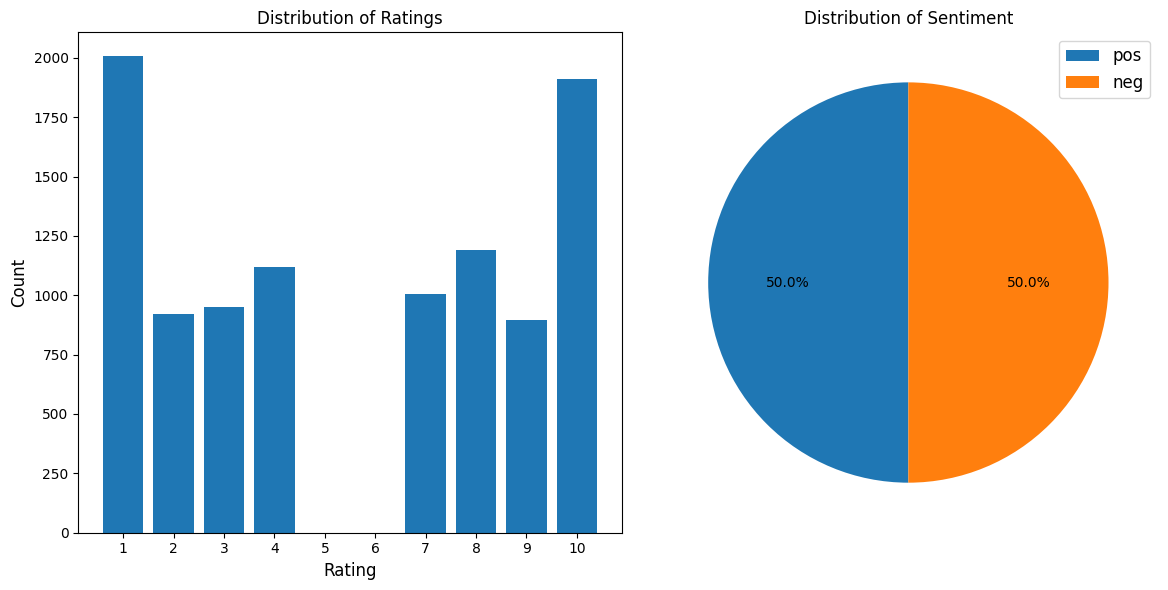

In [20]:
# Distribution of Ratings
rating_counts = balanced_data['Rating'].value_counts().sort_index()

# Distribution of Sentiment
sentiment_counts = balanced_data['Sentiment'].value_counts()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Distribution of Ratings
ax1.set_xticks(range(1, 11))
ax1.set_xticklabels(range(1, 11))
ax1.bar(rating_counts.index, rating_counts.values)
ax1.set_xlabel('Rating', fontsize=12)
ax1.set_ylabel('Count',  fontsize=12)
ax1.set_title('Distribution of Ratings')

# Plot Distribution of Sentiment
ax2.pie(sentiment_counts.values, 
        labels=None, 
        autopct='%1.1f%%', 
        startangle=90) # no labels, set as 1 decimal place, title the angle by 90 degree
ax2.set_title('Distribution of Sentiment')
ax2.legend(sentiment_counts.index, loc="best", fontsize=12)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

It can be seen that this dataframe contains 10000 with a <b>balanced distribution</b> of positive and negative sentiment data. The <b>most common rating</b> is 1 followed by 10. Both of them are the most frequent term in their sentiment respectively.

There is also <b>no null data</b> in all three columns.

<b>Collation</b> is obtained using BigramAssocMeasures from the NLTK library to analyze the relationship between nearby texts. This is useful to <b>identify negations</b>, which can pose challenges in the sentimental analysis when tokenizing data into n-grams.

For simplicity, the analysis will only focus on the negations for bigrams.

In [21]:
# Function to calculate collocations in a given text
def calculate_collocations(text):
    words = nltk.word_tokenize(text)
    finder = BigramCollocationFinder.from_words(words)
    finder.apply_freq_filter(2)  # Adjust the frequency threshold as needed
    collocations = finder.nbest(BigramAssocMeasures.pmi, 10)  
    return collocations

# Combine the content of balanced_data['Content'] into a single string
text = ' '.join(balanced_data['Content'])

# Calculate collocations for the combined text
collocations = calculate_collocations(text)

# Create a DataFrame to store the collocations and frequencies
collocations_df = pd.DataFrame(collocations, columns=['Word 1', 'Word 2'])
collocations_df['Frequency'] = collocations_df.apply(lambda row: text.count(' '.join(row)), axis=1)

# Sort the DataFrame by frequency in descending order
collocations_df = collocations_df.sort_values('Frequency', ascending=False).reset_index(drop=True)

The result is displayed below:

In [22]:
# Display the top 5 collocations with frequencies
collocations_df.head(10)

,Word 1,Word 2,Frequency
0,'Het,Gouden,2
1,'Independent,Thinkers,2
2,-Celluloid,Rehab,2
3,7eventy,5ive,2
4,8-12,y/o,2
5,ANCHORS,AWEIGH,2
6,ANDREI,RUBLEV,2
7,Adios,Companeros,2
8,Agusti,Villarona,2
9,Akosua,Busia,2


Based on the analysis above, there <b>does not</b> seem to be any negations as there is no common occurance of terms such as "not good" or "not nice".

Next, the entries were tokenized to examine the common words used in the reviews using frequency distribution:

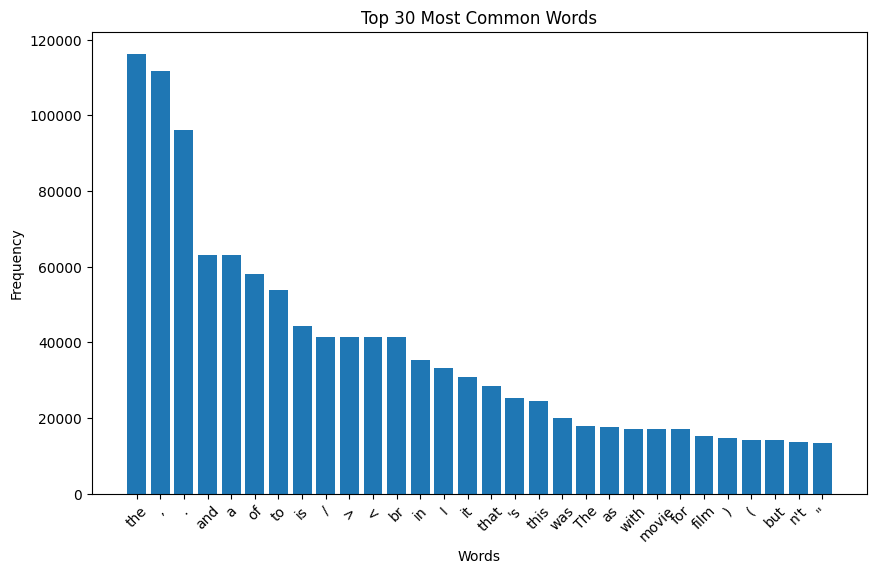

In [23]:
# Tokenize the words in the balanced_data["Content"] column
all_words = nltk.word_tokenize(' '.join(balanced_data["Content"]))

# Calculate the frequency distribution of words
freq_dist = FreqDist(all_words)

# Get the 30 most common words
most_common_words = freq_dist.most_common(30)

# Extract the words and their frequencies
words, frequencies = zip(*most_common_words)

# Plot the number of occurrences
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Most Common Words')
plt.xticks(rotation=45)
plt.show()

It was noted that most of the common words were <b>punctuation marks</b> (such as ",", ".", "<" and ">"), <b>determiners</b> (such as "the", "that", and "this") as well as <b>conjunctions</b> (such as "and", "for"). Thus a stopwords and punctuation removal is needed to obtain the part of the string that contains the most information. This will be done using the stopwords and Punkt tokenizer, which is a pre-trained sentence tokenizer available in NLTK.

Other common words that are present in the reviews are <b>related to the subject domain</b> (movie review. Some of the examples of these words are "movie" and "film".

It is also noted that besides the common stopwords and words that is related to the subject domain(moview review), there is also another commonly used term <b>"br"</b>. Further analysis of this term will thus be carried out.

<h4>Cleaning for the use of tags</h4>

Firstly, the data entries with term br is filtered out and displayed as below:

In [24]:
# Filter the entries containing "br"
filtered_data = balanced_data[balanced_data["Content"].str.contains("br")]

# Create a copy of the filtered DataFrame
filtered_data = filtered_data.copy()

# Extract the substring with 10 characters before and after "br"
filtered_data.loc[:, "Snippet"] = filtered_data["Content"].str.extract(r"(.{0,10}br.{0,10})")

# Display the filtered data
filtered_data[["Snippet"]]

,Snippet
0,"evel of Cobra Woman, e"
1,to like.<br /><br />O
7,Top Ten.<br /><br />P
9,to power.<br /><br />E
10,hen good.<br /><br />O
...,...
9987,sting....<br /><br />T
9988,udience).<br /><br />O
9990,MEMBERS.<br /><br />I
9993,cohorts.<br /><br />N


It is noticed that the dataset uses <b> &lt;br /&gt; tag </b> as a part of the content. This sytex is mostly used to symbolise a change of line. Thus, the &lt;br /&gt; will be <b>removed</b> as part of the stopwords removal. 

To prevent other issues related to tags, a further check is conducted to verify other usage of < /> and <> using <b>regular expression</b>.

In [25]:
# Check for other uses of tags using the term "< />"
# Filter the entries containing "<" and "/>"
data_tags = balanced_data[balanced_data["Content"].str.contains("<.*?/>")]

# Create a copy of the tags
data_tags = data_tags.copy()

# Extracting the substrings starts with "<" and end with "/>"
data_tags["tags"] = data_tags["Content"].str.extract(r"(<.*?/>)")

# Get the unique entries of tags
tags = data_tags["tags"].unique()

# Print the unique entries
for tag in tags:
    print(tag)

<br />
<3 <br />


The above algorithm confirms that the <b>only tag used</b> is &lt;br /&gt;

Thus, the data need to take not of the use of  &lt;br /&gt; when carry out stopwords removal

The frequency of the symbols for tags are also checked:

In [26]:
# Get the occurrences of tag markings
punctuation_occurrences = {
    "/": freq_dist["/"],
    "<": freq_dist["<"],
    ">": freq_dist[">"]
}

print("Occurrences of specific punctuation marks:")
for punctuation, count in punctuation_occurrences.items():
    print(f"{punctuation}: {count}")

Occurrences of specific punctuation marks:
/: 41426
<: 41351
>: 41390


From the algorithm above, it was noticed that the use of < and > were largely the same while the use of / is slightly higher.

This could indicate <b>other usage</b> of "/" besides tags.

Thus, the entire data is filtered again using regular expression which categorises every possible conbinations of the uses of "/" such as number / number and number / special characters.

In [27]:
# Checking other uses
content_column = balanced_data['Content']

# Define the categories
categories = {
    'num/num': r'(?P<before>\d+(\.\d+)?)/(?P<after>\d+(\.\d+)?)',
    'num/special': r'(?P<before>\d+(\.\d+)?)/(?P<after>[\W\t])',
    'special/num': r'(?P<before>[\W\t])/(?P<after>\d+(\.\d+)?)',
    'num/alpha': r'(?P<before>\d+(\.\d+)?)/(?P<after>[a-zA-Z])',
    'alpha/num': r'(?P<before>[a-zA-Z])/(?P<after>\d+(\.\d+)?)',
    'alpha/special': r'(?P<before>[a-zA-Z])/(?P<after>[^\w\s\t])',
    'special/alpha': r'(?P<before>[^\w\s\t])/(?P<after>[a-zA-Z\s])',
    'alpha/alpha': r'(?P<before>[a-zA-Z])/(?P<after>[a-zA-Z])',
    'special/special': r'(?P<before>[^\w\s\t])/(?P<after>[^\w\s\t])',
    'space/alpha': r'(?P<before>\s)/(?P<after>[a-zA-Z])',
    'alpha/space': r'(?P<before>[a-zA-Z])/(?P<after>\s)',
    'space/space': r'(?P<before>[\s\t])/(?P<after>[\s\t])'
}

# Categorize the strings and extract characters before and after "/"
results = []
for category, pattern in categories.items():
    matches = content_column.str.extractall(pattern)
    if not matches.empty:
        matches = matches.reset_index()
        matches = matches.rename(columns={'level_0': 'index'})
        matches = matches[['index', 'before', 'after']]
        matches['category'] = category
        results.append(matches)

# Combine the results into a single dataframe
if results:
    combined_results = pd.concat(results)
    combined_results = combined_results.reset_index(drop=True)  # Reset the index
else:
    combined_results = pd.DataFrame()


The frequency of the isage can be determined using the code below:

In [28]:
category_counts = combined_results['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']
category_counts = category_counts.sort_values('count', ascending=False)
print(category_counts)

           category  count
0       alpha/alpha   1515
1           num/num    971
2       space/space     91
3       alpha/space     46
4     special/alpha     45
5   special/special     42
6         alpha/num     17
7         num/alpha     15
8       space/alpha     15
9     alpha/special     14
10      num/special      8
11      special/num      6


The most common usage of the "/" is examined and shown below:

In [29]:
a_a_df = combined_results[combined_results['category'] == 'alpha/alpha'].copy()
a_a_df.head(5)

,index,before,after,category
1076,23,o,h,alpha/alpha
1077,32,t,p,alpha/alpha
1078,32,r,d,alpha/alpha
1079,54,d,o,alpha/alpha
1080,69,e,s,alpha/alpha


In [30]:
num_num_df = combined_results[combined_results['category'] == 'num/num'].copy()
num_num_df.head(5)

,index,before,after,category
0,43,10,10,num/num
1,94,10,10,num/num
2,99,10,10,num/num
3,100,8,10,num/num
4,116,9,10,num/num


With that in mind, the original data was re-examined and realised the most common usage of"/" is for <b>choices between two words</b> (Eg. June/July), while the second most common usage is <b>two numbers</b> to show a rating (Eg. 8.5/10). 

Thus, when carrying out text processing pipelines later, <b>&lt;br /&gt; will be removed </b>as it is tag that provides little insights about the text. Moreover, numbers around "/" in the form of <b>number / number</b> will also be <b>removed</b> as it could provide information about the rating given by the viewer which should not be seen by the model.

A column in the dataframe is created to store the data to be removed:

In [31]:
num_num_df['string_removal'] = num_num_df['before'] + '/' + num_num_df['after']
num_num_df

,index,before,after,category,string_removal
0,43,10,10,num/num,10/10
1,94,10,10,num/num,10/10
2,99,10,10,num/num,10/10
3,100,8,10,num/num,8/10
4,116,9,10,num/num,9/10
...,...,...,...,...,...
966,9942,2,3,num/num,2/3
967,9947,1,10,num/num,1/10
968,9962,1,4,num/num,1/4
969,9962,2,10,num/num,2/10


The data is now ready to be tokenized and transformed into a simpler term for a more detailed Natural Language Processing analysis

<h4>Tokenization and lemmatization</h4>

In [32]:
# Download NLTK resources
nltk.download('stopwords', quiet=True) # Stop words removal
nltk.download('wordnet', quiet=True) # Lemmatization
nltk.download('words', quiet=True) # Spelling check
nltk.download('maxent_ne_chunker', quiet=True) # Expand short forms

True

In [33]:
def expand_short_forms(word, previous_word):
    if word == "'s":
        # Check if the previous word is a proper noun or named entity
        if previous_word[0].isupper() or isinstance(ne_chunk([(previous_word, '')]), Tree):
            # Likely indicating possession
            return word
        else:
            # Likely contraction of "is"
            return "is"
    elif word == "n't":
        return "not"
    else:
        return word

In [34]:
# Function to preprocess the text
def text_processing_pipeline(text, string=None, column=None):
    # Replace string entries
    if string is not None:
        text = text.replace(string, '')

    # Remove elements in specified column
    if column is not None:
        for element in column:
            text = text.replace(element, '')
    
    # Change all text to lower case
    text = text.lower()
    
    # Convert short forms to full format
    words = text.split()
    expanded_words = [expand_short_forms(word, words[i-1]) if i > 0 else word for i, word in enumerate(words)]
    text = ' '.join(expanded_words)

    # Remove the spacial character from the text
    text = re.sub(r'[^a-z0-9]', ' ', text)

    # Tokenization
    words = word_tokenize(text)
    
    # Stop Words removal, result stored in words
    stop_words = set(stopwords.words('english'))
    words = (word for word in words if word not in stop_words)
    
    # change to synonyms and reduce word form
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Combine the words back
    text = ' '.join(word for word in words)

    # Removing spaces before and after the text
    text = text.strip()

    # Change the spaces with length more than 1 to 1
    text = re.sub(r'\s+', ' ', text)

    return text

In [35]:
# make a copy of the balanced data
processed_data = balanced_data.copy()

# Iteratively run the processing pipeline on every entry of content
for i in range(len(balanced_data)):
    processed_data.loc[i, 'Content'] = text_processing_pipeline(processed_data.loc[i, 'Content'], "<br />", num_num_df['string_removal'])
processed_data

,Sentiment,Rating,Content
0,pos,7,much underrated camp movie level cobra woman e...
1,pos,8,unusual laurel hardy comedy something split pe...
2,pos,9,first saw movie theater came crowd really movi...
3,pos,10,husband enjoy doodlebops much 8 month old baby...
4,pos,10,one disney best film enjoy watching often may ...
...,...,...,...
9995,neg,4,generally rated movie boast strong cast clever...
9996,neg,2,shocking 1965 saw jury gagarin alive sincere u...
9997,neg,3,dull cheap sci fi thriller made almost total l...
9998,neg,2,like title thread say impression got movie mar...


the following algorithm is used to check if the text has all being processed.

In [36]:
# Check the success of text processing
success_count = 0
for original_text, processed_text in zip(balanced_data['Content'], processed_data['Content']):

    if original_text == processed_text:
        print("Text processing failed")
    else:
        success_count +=1
if success_count == len(processed_data['Content']):
    print("Text processing success")

Text processing success


<h3 id="2.1.3">2.3 Vocabulary statistic</h3>

<h4>lexical analysis:</h4>

Lexical Diversity is calculated using the equation below. It measure of how diverse the vocabulary used in the positive and negative reviews by examining the ratio of unique words to the total number of words in the text.

$$
\text{Lexical Diversity} = \frac{\text{Number of Unique Words}}{\text{Total Number of Words}}
$$


In [37]:
# Separate the data based on sentiment
positive_data = processed_data[processed_data['Sentiment'] == 'pos']
negative_data = processed_data[processed_data['Sentiment'] == 'neg']

In [38]:
# Helper function to calculate the lexical diversity
def calculate_lexical_diversity(text):
    all_words = nltk.word_tokenize(text)
    total_words = len(all_words)
    unique_words = len(set(all_words))
    lexical_diversity = unique_words / total_words
    return lexical_diversity

In [39]:
pos_lexical_diversity = calculate_lexical_diversity(' '.join(positive_data["Content"]))
neg_lexical_diversity = calculate_lexical_diversity(' '.join(negative_data["Content"]))

print("Lexical Diversity (Positive Sentiment):", pos_lexical_diversity)
print("Lexical Diversity (Negative Sentiment):", neg_lexical_diversity)

Lexical Diversity (Positive Sentiment): 0.05546672386560848
Lexical Diversity (Negative Sentiment): 0.05509503931464607


Based on the analysis above, both datasets has similar lexical diversity.

<h4>frequency distribution</h4>

Checking the most common words and frequency distribution after tokenizing, lemmatizing and stopwords removal:

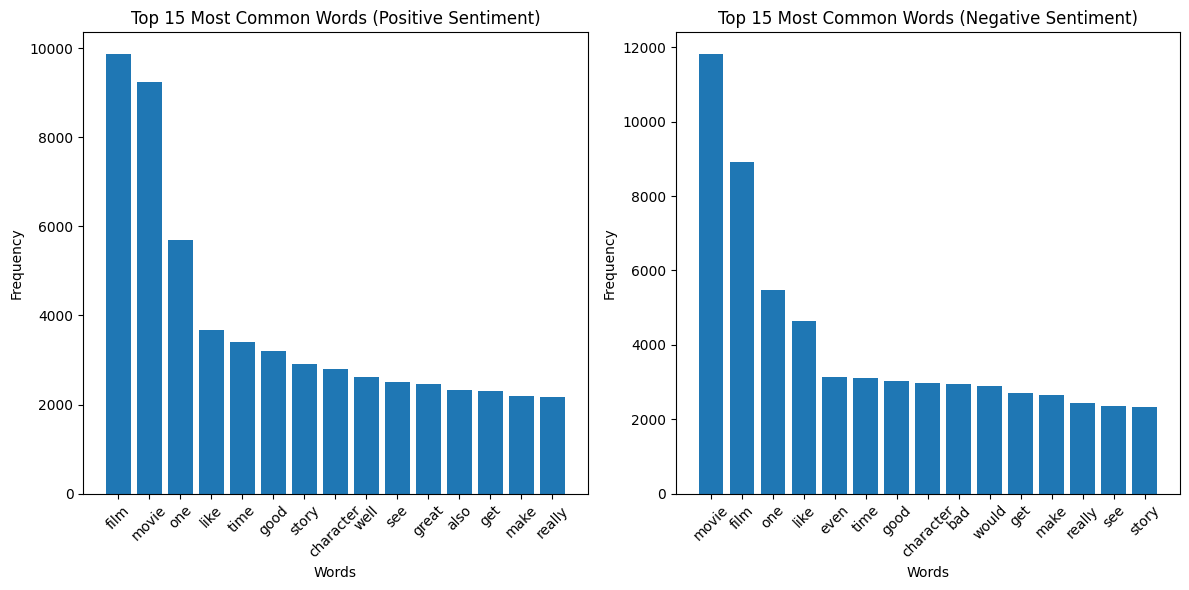

In [40]:
# Tokenize the words in the positive_data["Content"] column
positive_words = nltk.word_tokenize(' '.join(positive_data["Content"]))
positive_freq_dist = FreqDist(positive_words)
positive_common_words = positive_freq_dist.most_common(15)
positive_words, positive_frequencies = zip(*positive_common_words)

# Tokenize the words in the negative_data["Content"] column
negative_words = nltk.word_tokenize(' '.join(negative_data["Content"]))
negative_freq_dist = FreqDist(negative_words)
negative_common_words = negative_freq_dist.most_common(15)
negative_words, negative_frequencies = zip(*negative_common_words)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for positive sentiments
ax1.bar(positive_words, positive_frequencies)
ax1.set_xlabel('Words')
ax1.set_ylabel('Frequency')
ax1.set_title('Top 15 Most Common Words (Positive Sentiment)')
ax1.tick_params(axis='x', rotation=45)

# Plot for negative sentiments
ax2.bar(negative_words, negative_frequencies)
ax2.set_xlabel('Words')
ax2.set_ylabel('Frequency')
ax2.set_title('Top 15 Most Common Words (Negative Sentiment)')
ax2.tick_params(axis='x', rotation=45)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

From above, the most common occurance of words are film and movie. <b>Most</b> of the common words in both sentiment review dataset have a <b>neutral connotation</b>. For the top 15 most commonly used words, <b>two words</b> (good, great) in the positive sentiment data set have a <b>positive connotation</b> while there is only <b>one word</b> in the negative sentiment data set has a <b>negative connotation</b>. It is interesting to see that one word (good) with string positive connotation are present in the negative sentiment dataset. Assuming the dataset is labbeled correctly, this could be due to the <b>problem of negation</b>

A word cloud is generated to show the distribution of the words

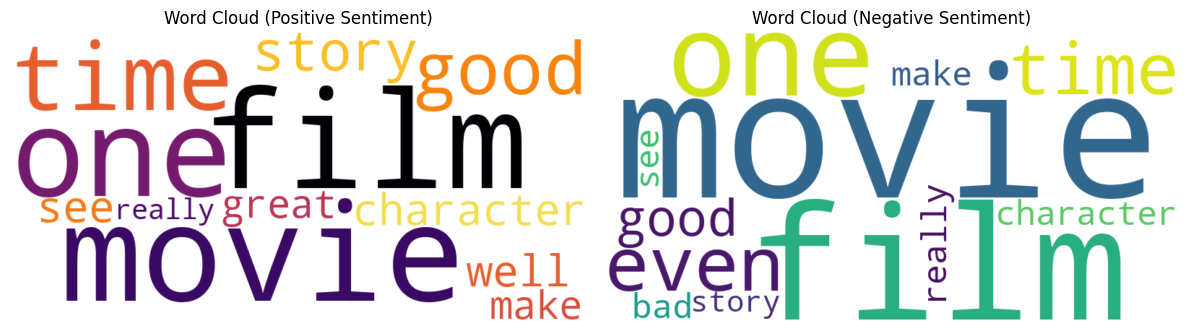

In [41]:
# Generate word cloud for positive sentiments
positive_wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='inferno').generate(' '.join(positive_words))

# Generate word cloud for negative sentiments
negative_wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='viridis').generate(' '.join(negative_words))

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for positive sentiments
ax1.imshow(positive_wordcloud, interpolation='bilinear')
ax1.set_title('Word Cloud (Positive Sentiment)')
ax1.axis('off')

# Plot for negative sentiments
ax2.imshow(negative_wordcloud, interpolation='bilinear')
ax2.set_title('Word Cloud (Negative Sentiment)')
ax2.axis('off')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

Preparing data for Machine Learning:

In [42]:
# Predicting sentiment base on the content, thus X (features) is the content and y (target variable) is the sentiment
X = processed_data['Content']
y = processed_data['Sentiment']

In [43]:
# Split data into training and testing data with a test size of 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# Save in testing and training data in a new dataframe
train_data = pd.DataFrame({'Content': X_train, 'Sentiment': y_train})
test_data = pd.DataFrame({'Content': X_test, 'Sentiment': y_test})

To achieve consistency, data is saved in the csv file

In [45]:
# Save data in csv file
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

In [46]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

<h3 id="2.2">2.2 Baseline Performance</h3>

Evaluation matrix:

In [47]:
from sklearn.metrics import mean_squared_error

def evaluation(y_true, y_pred):
    # Calculate accuracy
    accuracy = (y_true == y_pred).mean()

    # Construct confusion matrix
    confusion_matrix = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'])

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    # Calculate mean squared error
    mse = mean_squared_error(y_true, y_pred)

    # Print the evaluation metrics
    print("Accuracy:", accuracy)
    print("=" * 50)
    print("Confusion Matrix:\n", confusion_matrix)
    print("=" * 50)
    print("Precision:", precision)
    print("=" * 50)
    print("Recall:", recall)
    print("=" * 50)
    print("F1 Score:", f1)
    print("=" * 50)
    print("Mean Squared Error:", mse)

    return accuracy, confusion_matrix, precision, recall, f1, mse


Deploying the BERT model

In [48]:
tokenizer = AutoTokenizer.from_pretrained('textattack/bert-base-uncased-imdb')
model = AutoModelForSequenceClassification.from_pretrained('textattack/bert-base-uncased-imdb')

In [49]:
test_data = pd.read_csv('test_data.csv')
content_test = test_data['Content'].tolist()
sentiment_test = test_data['Sentiment'].tolist()

In [50]:
# Initialize empty lists for predictions and evaluation metrics
predictions = []
y_true = []

In [51]:
# Iterate over the test data
for content, sentiment in zip(content_test, sentiment_test):
    # Encode the content using the tokenizer
    tokens = tokenizer.encode_plus(content, add_special_tokens=True, padding='max_length', max_length=128, truncation=True, return_tensors='pt')
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    prediction = outputs.logits.argmax(dim=1).item()

    # Append the prediction and true label to the lists
    predictions.append(prediction)

In [52]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Convert labels from strings to numerical values
sentiment_encoded = label_encoder.fit_transform(sentiment_test)

# Convert the lists to numpy arrays
y_pred = np.array(predictions)
y_true = np.array(sentiment_encoded)  # Use the encoded labels instead of sentiment_test

In [53]:
# Call the evaluation function
accuracy_BERT, confusion_matrix_BERT, precision_BERT, recall_BERT, f1_BERT, mse_BERT = evaluation(y_true, y_pred)

Accuracy: 0.8655
Confusion Matrix:
 Predicted    0    1
Actual             
0          936   52
1          217  795
Precision: 0.8752010821316191
Recall: 0.866470771791138
F1 Score: 0.8648281621730405
Mean Squared Error: 0.1345


Training and running the model RNN

stopwords removal - high tf is likely to be the stop words

In [126]:
# Load the training data
train_data = pd.read_csv('train_data.csv')

# Extract the content and sentiment columns
content = train_data['Content'].tolist()
sentiment = train_data['Sentiment'].tolist()

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(content, sentiment, test_size=0.2, random_state=42)

# Tokenize the text data
tokenizer = Tokenizer(num_words=4000)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

# Pad sequences to have consistent length
X_train_padded = pad_sequences(X_train_sequences, maxlen=400, padding='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=400, padding='post')

# Convert sentiment labels to numeric
sentiment_mapping = {'pos': 1, 'neg': 0}
y_train_numeric = np.array([sentiment_mapping[sent] for sent in y_train])
y_val_numeric = np.array([sentiment_mapping[sent] for sent in y_val])

In [127]:
# Build the RNN model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 32, input_length=400))
model.add(Dropout(0.25)) # add drop out
model.add(LSTM(units=16, dropout=0.2, recurrent_dropout=0.2)) 
model.add(Dropout(0.25)) # add drop out
model.add(Dense(units=256, activation='relu')) 
model.add(Dropout(0.25)) # add drop out
model.add(Dense(units=1, activation='sigmoid')) 

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train_numeric, validation_data=(X_val_padded, y_val_numeric), 
          epochs=10, verbose=2, batch_size=128)

# Save the trained model
model.save("trained_model_RNN.h5")

Epoch 1/10
50/50 - 22s - loss: 0.6933 - accuracy: 0.4981 - val_loss: 0.6933 - val_accuracy: 0.4988 - 22s/epoch - 432ms/step
Epoch 2/10
50/50 - 17s - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy: 0.5013 - 17s/epoch - 343ms/step
Epoch 3/10
50/50 - 17s - loss: 0.6933 - accuracy: 0.4941 - val_loss: 0.6932 - val_accuracy: 0.4988 - 17s/epoch - 344ms/step
Epoch 4/10
50/50 - 17s - loss: 0.6933 - accuracy: 0.4969 - val_loss: 0.6932 - val_accuracy: 0.4988 - 17s/epoch - 347ms/step
Epoch 5/10
50/50 - 17s - loss: 0.6930 - accuracy: 0.4942 - val_loss: 0.6931 - val_accuracy: 0.4988 - 17s/epoch - 346ms/step
Epoch 6/10
50/50 - 18s - loss: 0.6919 - accuracy: 0.5069 - val_loss: 0.6929 - val_accuracy: 0.5006 - 18s/epoch - 353ms/step
Epoch 7/10
50/50 - 17s - loss: 0.6906 - accuracy: 0.4981 - val_loss: 0.6927 - val_accuracy: 0.4988 - 17s/epoch - 349ms/step
Epoch 8/10
50/50 - 17s - loss: 0.6903 - accuracy: 0.4961 - val_loss: 0.6926 - val_accuracy: 0.4988 - 17s/epoch - 346ms/step
Epoch 9/

In [128]:
# Load the test data
test_data = pd.read_csv('test_data.csv')

# Extract the content and sentiment columns
content_test = test_data['Content'].tolist()
sentiment_test = test_data['Sentiment'].tolist()

# Tokenize the test data
test_sequences = tokenizer.texts_to_sequences(content_test)

# Pad sequences
test_sequences_padded = pad_sequences(test_sequences, maxlen=400, padding='post')

# Convert sentiment labels to numeric
y_test_numeric = np.array([sentiment_mapping[sent] for sent in sentiment_test])

# Evaluate the model on the test data
y_pred_prob = model.predict(test_sequences_padded)
y_pred = (y_pred_prob > 0.5).astype(int)
y_pred = y_pred.flatten()  # Flatten the predictions to match the shape of y_test_numeric

# Call the evaluation function
accuracy_RNN, confusion_matrix_RNN, precision_RNN, recall_RNN, f1_RNN, mse_RNN=evaluation(y_test_numeric, y_pred)

63/63 [==============================] - 4s 59ms/step
Accuracy: 0.506
Confusion Matrix:
 Predicted  0     1
Actual            
0          7   981
1          7  1005
Precision: 0.5030211480362538
Recall: 0.5000840120977421
F1 Score: 0.3422095102656595
Mean Squared Error: 0.494


Naive Bayes classifier

fast for training and testing, suitable for high dimensional dataset.

tf-idf measure the originality of the words. TF(t,d)*IDF(t) identify sigificant words. Number of times word appear/total words. 

In [57]:
# Following code is self written 
# Load the training data
train_data = pd.read_csv('train_data.csv')

# Extract the content and sentiment columns
content = train_data['Content'].tolist()
sentiment = train_data['Sentiment'].tolist()

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(content, sentiment, test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Vectorize the content data
X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)

# Train a Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train_vectorized, y_train)

# Make predictions on the validation set
val_predictions = model.predict(X_val_vectorized)

In [58]:
# Convert sentiment labels to numeric
y_val_numeric = np.array([sentiment_mapping[sent] for sent in y_val])
val_predictions_numeric = np.array([sentiment_mapping[sent] for sent in val_predictions])

# Calculate the accuracy
accuracy = accuracy_score(y_val_numeric, val_predictions_numeric)

# Print the evaluation metrics
accuracy_NB, confusion_matrix_NB, precision_NB, recall_NB, f1_NB, mse_NB = evaluation(y_val_numeric, val_predictions_numeric)

Accuracy: 0.85375
Confusion Matrix:
 Predicted    0    1
Actual             
0          720   78
1          156  646
Precision: 0.8570915007946719
Recall: 0.8538709616935105
F1 Score: 0.8534364914950887
Mean Squared Error: 0.14625


SVM

In [59]:
# Load the training data
train_data = pd.read_csv('train_data.csv')

# Extract the content and sentiment columns
content = train_data['Content'].tolist()
sentiment = train_data['Sentiment'].tolist()

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(content, sentiment, test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Vectorize the content data
X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)

# Train an SVM classifier
model = SVC()
model.fit(X_train_vectorized, y_train)

# Make predictions on the validation set
val_predictions = model.predict(X_val_vectorized)

In [60]:
# Convert string labels to numeric format
label_encoder = LabelEncoder()
y_val_numeric = label_encoder.fit_transform(y_val)
val_predictions_numeric = label_encoder.transform(val_predictions)

# Calculate accuracy
accuracy = accuracy_score(y_val_numeric, val_predictions_numeric)

# Print the evaluation metrics
accuracy_SVM, confusion_matrix_SVM, precision_SVM, recall_SVM, f1_SVM, mse_SVM=evaluation(y_val_numeric, val_predictions_numeric)

print("Validation Accuracy:" )

Accuracy: 0.883125
Confusion Matrix:
 Predicted    0    1
Actual             
0          694  104
1           83  719
Precision: 0.8834059714983166
Recall: 0.8830914568216051
F1 Score: 0.8830964590964592
Mean Squared Error: 0.116875
Validation Accuracy:


Logistic Regression (Bag of word)

In [61]:
# Extract the content and sentiment columns
content = train_data['Content'].tolist()
sentiment = train_data['Sentiment'].tolist()

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(content, sentiment, test_size=0.2, random_state=42)

# Create a CountVectorizer
vectorizer = CountVectorizer()

# Vectorize the content data
X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)

# Scale the vectorized data
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_vectorized)
X_val_scaled = scaler.transform(X_val_vectorized)

# Train a Logistic Regression classifier
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vectorized, y_train)

# Make predictions on the validation set
val_predictions = model.predict(X_val_vectorized)

In [62]:
# Convert string labels to numeric format
label_encoder = LabelEncoder()
y_val_numeric = label_encoder.fit_transform(y_val)
val_predictions_numeric = label_encoder.transform(val_predictions)

# Calculate accuracy
accuracy = accuracy_score(y_val_numeric, val_predictions_numeric)

# Print the evaluation metrics
accuracy_BoW, confusion_matrix_BoW, precision_BoW, recall_BoW, f1_BoW, mse_BoW=evaluation(y_val_numeric, val_predictions_numeric)

Accuracy: 0.86375
Confusion Matrix:
 Predicted    0    1
Actual             
0          688  110
1          108  694
Precision: 0.8637528438210955
Recall: 0.8637460234126463
F1 Score: 0.8637480839574306
Mean Squared Error: 0.13625


In [63]:
# Extract the content and sentiment columns
content = train_data['Content'].tolist()
sentiment = train_data['Sentiment'].tolist()

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(content, sentiment, test_size=0.2, random_state=42)

# Create a CountVectorizer
vectorizer = CountVectorizer()

# Vectorize the content data
X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)

# Apply cross-validation to find the best regularization parameter
model = LogisticRegressionCV(penalty='l2', solver='lbfgs', cv=5, max_iter=1000)
model.fit(X_train_vectorized, y_train)

# Make predictions on the validation set
val_predictions = model.predict(X_val_vectorized)

In [64]:
# Convert string labels to numeric format
label_encoder = LabelEncoder()
y_val_numeric = label_encoder.fit_transform(y_val)
val_predictions_numeric = label_encoder.transform(val_predictions)

# Calculate accuracy
accuracy = accuracy_score(y_val_numeric, val_predictions_numeric)

# Print the evaluation metrics
accuracy_LR, confusion_matrix_LR, precision_LR, recall_LR, f1_LR, mse_LR=evaluation(y_val_numeric, val_predictions_numeric)

Accuracy: 0.878125
Confusion Matrix:
 Predicted    0    1
Actual             
0          698  100
1           95  707
Precision: 0.878143014074515
Recall: 0.8781164257276608
F1 Score: 0.8781211436768116
Mean Squared Error: 0.121875


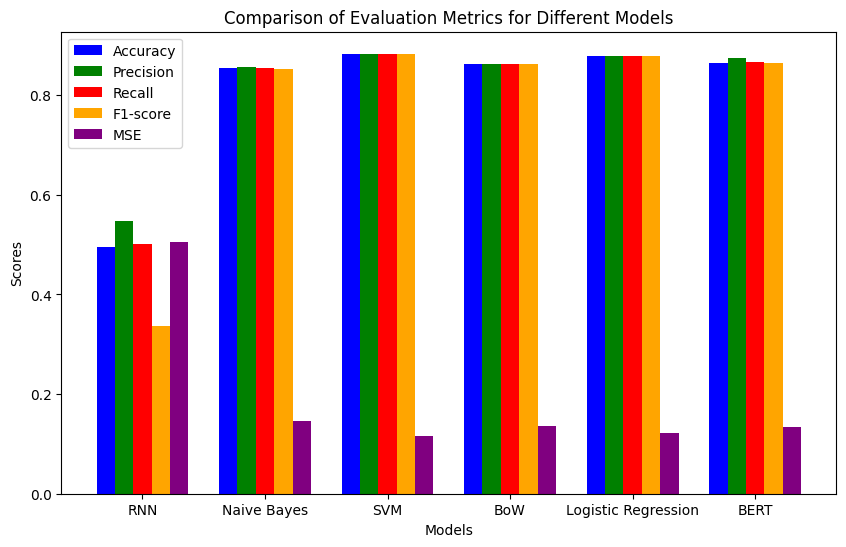

In [69]:
# Create a list of model names
models = ['RNN','Naive Bayes', 'SVM', 'BoW', 'Logistic Regression', 'BERT']

# Create a list of evaluation metrics
accuracy_scores = [accuracy_RNN, accuracy_NB, accuracy_SVM, accuracy_BoW, accuracy_LR, accuracy_BERT]
precision_scores = [precision_RNN, precision_NB, precision_SVM, precision_BoW, precision_LR, precision_BERT]
recall_scores = [recall_RNN, recall_NB, recall_SVM, recall_BoW, recall_LR, recall_BERT]
f1_scores = [f1_RNN, f1_NB, f1_SVM, f1_BoW, f1_LR, f1_BERT]
mse_scores = [mse_RNN, mse_NB, mse_SVM, mse_BoW, mse_LR, mse_BERT]

plt.figure(figsize=(10, 6))

# Set the width of each bar
bar_width = 0.15

# Set the position of each bar on the x-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]

# Plot the grouped bar plot
plt.bar(r1, accuracy_scores, color='b', width=bar_width, label='Accuracy')
plt.bar(r2, precision_scores, color='g', width=bar_width, label='Precision')
plt.bar(r3, recall_scores, color='r', width=bar_width, label='Recall')
plt.bar(r4, f1_scores, color='orange', width=bar_width, label='F1-score')
plt.bar(r5, mse_scores, color='purple', width=bar_width, label='MSE')

# Add x-axis ticks and labels
plt.xlabel('Models')
plt.ylabel('Scores')
plt.xticks([r + bar_width * 2 for r in range(len(models))], models)
plt.title('Comparison of Evaluation Metrics for Different Models')

# Add a legend
plt.legend()

# Display the plot
plt.show()

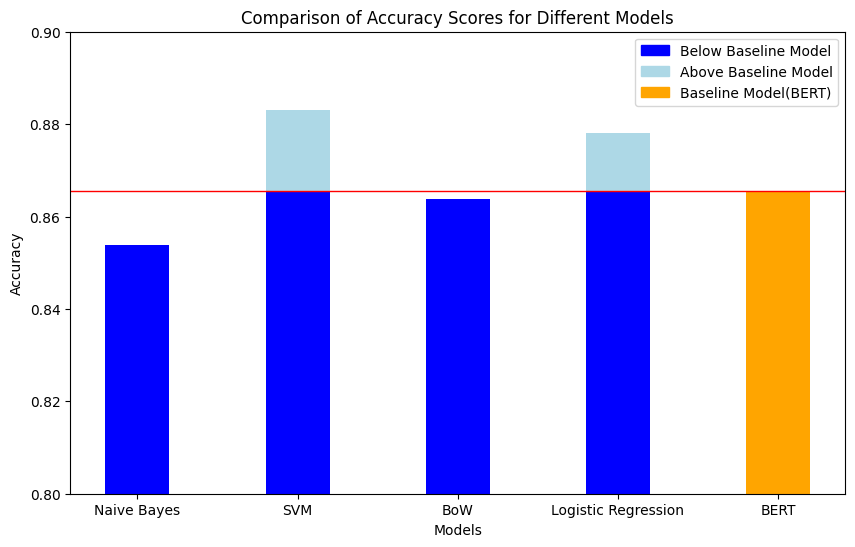

In [95]:
# Create a list of model names
models = ['Naive Bayes', 'SVM', 'BoW', 'Logistic Regression', 'BERT']

# Create a list of accuracy scores
accuracy_scores = [accuracy_NB, accuracy_SVM, accuracy_BoW, accuracy_LR, accuracy_BERT]

plt.figure(figsize=(10, 6))

# Set the width of each bar
bar_width = 0.4

# Set the position of each bar on the x-axis
r = np.arange(len(models))

# Initialize the bottom position of the bars
bottom = np.zeros(len(models))

# Plot the accuracy scores with blue color below the red line
plt.bar(r, accuracy_scores, bottom=bottom, color='b', width=bar_width)
plt.bar(r[-1], accuracy_scores[-1], color='orange', width=bar_width)  # BERT plot in orange

# Draw a line at the top of the BERT bar
plt.axhline(y=accuracy_scores[-1], color='red', linestyle='-', linewidth=1)

# Set the y-axis limits to focus on the desired region
plt.ylim(0.8, 0.9)  # Adjust the limits

# Plot the accuracy scores with light blue color above the red line
plt.bar(r, np.where(accuracy_scores > accuracy_scores[-1], 
                    accuracy_scores - accuracy_scores[-1], 0), 
        bottom=accuracy_scores[-1],
        color='lightblue', width=bar_width)

# Add x-axis ticks and labels
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(r, models)
plt.title('Comparison of Accuracy Scores for Different Models')

# Add legend
below = mpatches.Patch(color='b', label='Below Baseline Model')
above = mpatches.Patch(color='lightblue', label='Above Baseline Model')
base = mpatches.Patch(color='orange', label='Baseline Model(BERT)')
plt.legend(handles=[below, above,base])

# Display the plot
plt.show()

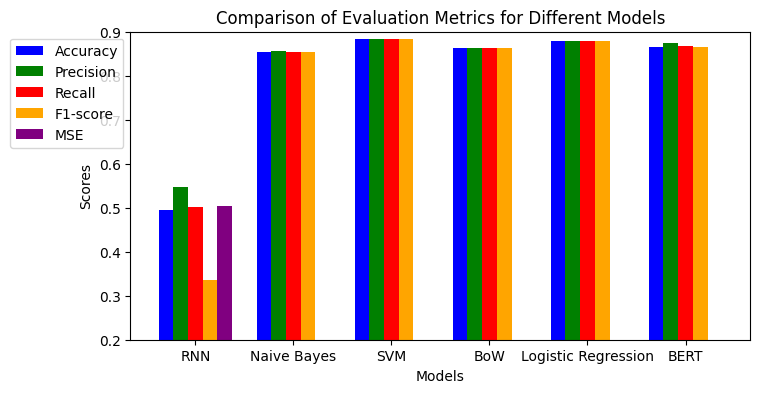

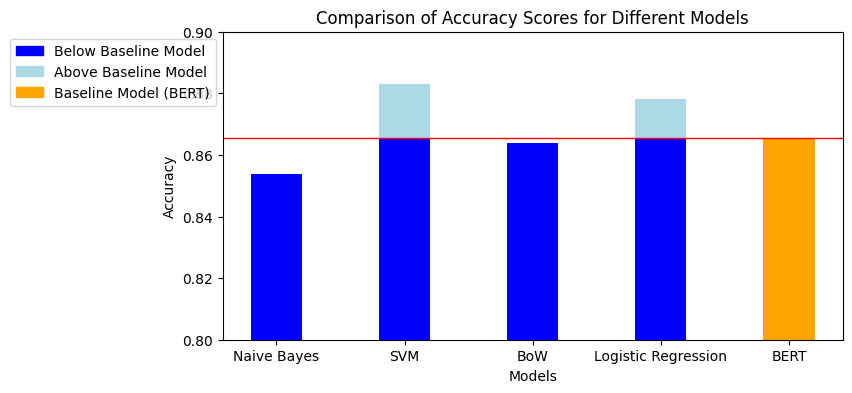

In [114]:
# First plot
models_1 = ['RNN', 'Naive Bayes', 'SVM', 'BoW', 'Logistic Regression', 'BERT']

accuracy_scores_1 = [accuracy_RNN, accuracy_NB, accuracy_SVM, accuracy_BoW, accuracy_LR, accuracy_BERT]
precision_scores_1 = [precision_RNN, precision_NB, precision_SVM, precision_BoW, precision_LR, precision_BERT]
recall_scores_1 = [recall_RNN, recall_NB, recall_SVM, recall_BoW, recall_LR, recall_BERT]
f1_scores_1 = [f1_RNN, f1_NB, f1_SVM, f1_BoW, f1_LR, f1_BERT]
mse_scores_1 = [mse_RNN, mse_NB, mse_SVM, mse_BoW, mse_LR, mse_BERT]

# Set the width of each bar
bar_width = 0.15

plt.figure(figsize=(8, 4))  # Increase the figure size

# Set the position of each bar on the x-axis
r1 = np.arange(len(models_1))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]

# Plot the grouped bar plot
plt.bar(r1, accuracy_scores_1, color='b', width=bar_width, label='Accuracy')
plt.bar(r2, precision_scores_1, color='g', width=bar_width, label='Precision')
plt.bar(r3, recall_scores_1, color='r', width=bar_width, label='Recall')
plt.bar(r4, f1_scores_1, color='orange', width=bar_width, label='F1-score')
plt.bar(r5, mse_scores_1, color='purple', width=bar_width, label='MSE')
plt.ylim(0.2, 0.9)  # Adjust the limits


# Add x-axis ticks and labels
plt.xlabel('Models')
plt.ylabel('Scores')
plt.xticks([r + bar_width * 2 for r in range(len(models_1))], models_1)
plt.title('Comparison of Evaluation Metrics for Different Models')

# Add a legend
plt.legend(bbox_to_anchor=(0, 1))

# Second plot
models_2 = ['Naive Bayes', 'SVM', 'BoW', 'Logistic Regression', 'BERT']
accuracy_scores_2 = [accuracy_NB, accuracy_SVM, accuracy_BoW, accuracy_LR, accuracy_BERT]

plt.figure(figsize=(8, 4))  # Increase the figure size

# Set the width of each bar
bar_width = 0.4

# Set the position of each bar on the x-axis
r = np.arange(len(models_2))

# Initialize the bottom position of the bars
bottom = np.zeros(len(models_2))

# Plot the accuracy scores with blue color below the red line
blue_bars = plt.bar(r, accuracy_scores_2, bottom=bottom, color='b', width=bar_width)
plt.bar(r[-1], accuracy_scores[-1], color='orange', width=bar_width)  # BERT plot in orange

# Draw a line at the top of the BERT bar
plt.axhline(y=accuracy_scores_2[-1], color='red', linestyle='-', linewidth=1)

# Set the y-axis limits to focus on the desired region
plt.ylim(0.8, 0.9)  # Adjust the limits

# Plot the accuracy scores with light blue color above the red line
lightblue_bars = plt.bar(r, np.where(accuracy_scores_2 > accuracy_scores_2[-1],
                                     accuracy_scores_2 - accuracy_scores_2[-1], 0),
                         bottom=accuracy_scores_2[-1],
                         color='lightblue', width=bar_width)

# Add x-axis ticks and labels
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(r, models_2)
plt.title('Comparison of Accuracy Scores for Different Models')

# Add legend
below = mpatches.Patch(color='b', label='Below Baseline Model')
above = mpatches.Patch(color='lightblue', label='Above Baseline Model')
base = mpatches.Patch(color='orange', label='Baseline Model (BERT)')
plt.legend(handles=[below, above, base], bbox_to_anchor=(0, 1))

# Display the plots
plt.show()

<h2 id="Conc">3. Conclusion</h2>

<h3 id="3.1">3.1 Evaluation</h3>

<h3 id="3.2">3.2 Project Evaluation and Summary</h3>